In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import umap
import gc

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor

sns.set_style('white')

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# break

In [3]:
# model = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224"
model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.dataset"
outpath = "/scratch/indikar_root/indikar1/cstansbu/geneformer"

In [8]:
def load_and_subset_data(data_path: str, num_cells: int = 100) -> pd.DataFrame:
    """Loads a dataset from disk, selects a subset of cells, and converts it to a Pandas DataFrame.

    Args:
        data_path (str): Path to the dataset file.
        num_cells (int, optional): Number of cells to include in the subset (default: 100).

    Returns:
        pd.DataFrame: The subset of data as a Pandas DataFrame.
    """

    data = load_from_disk(data_path)
    if num_cells > len(data):
        raise ValueError(f"Requested subset size ({num_cells}) exceeds dataset length ({len(data)})")

    data_subset = data.select([i for i in range(num_cells)])
    df = data_subset.to_pandas()

    return df

# Example usage:
df = load_and_subset_data(data_path, num_cells=66)

df.head()

,input_ids,dataset,sample_id,timepoint,hour,n_counts,control,length
0,"[10920, 4415, 7492, 11900, 11350, 10027, 3584,...",liu_2018,63246,1.0,-48.0,11940999,True,2048
1,"[4415, 10920, 7492, 10027, 11350, 3584, 1732, ...",liu_2018,63252,2.0,0.0,18063509,False,2048
2,"[4415, 10920, 7492, 2852, 10027, 11350, 3584, ...",liu_2018,63249,3.0,8.0,11031474,False,2048
3,"[7492, 4415, 10920, 9235, 6013, 6839, 10939, 5...",liu_2018,63261,1.0,16.0,16761043,False,2048
4,"[7492, 4415, 10920, 11900, 16683, 10027, 6013,...",liu_2018,63258,2.0,24.0,8244802,False,2048


In [ ]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [10]:
torch.cuda.empty_cache()

n_cells = 66
# 0 for last layer, -1 for second to last
layer = 0 

# initiate EmbExtractor
embex = EmbExtractor(model_type="Pretrained",
                     num_classes=0,
                     max_ncells=n_cells,
                     emb_mode='cell',
                     emb_layer=layer,
                     emb_label=["dataset", "sample_id", "timepoint", "hour", 'control'],
                     forward_batch_size=30,
                     nproc=16,
                      )

# extracts embedding from input data
embs = embex.extract_embs(model,
                          data_path,
                          outpath,
                          "test")


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


In [11]:
embs.head()

,0,1,2,3,4,5,6,7,8,9,...,507,508,509,510,511,dataset,sample_id,timepoint,hour,control
0,-0.267749,-0.562284,1.086843,-0.220784,0.304524,0.122247,-0.005547,-0.323727,0.460995,0.477571,...,0.379134,-0.004659,-0.436545,0.354680,-0.386282,liu_2018,63246,1.0,-48.0,True
1,-0.305709,-0.638381,0.890797,-0.211967,0.294883,0.121767,0.249747,-0.481699,0.611989,0.449617,...,0.304695,-0.211474,-0.581763,0.195274,-0.246072,liu_2018,63252,2.0,0.0,False
2,-0.137678,-0.415226,1.010852,-0.328790,0.320330,0.170488,-0.041598,-0.333038,0.571108,0.411519,...,0.456451,-0.176525,-0.435575,0.274627,-0.342817,liu_2018,63249,3.0,8.0,False
3,-0.092060,-0.441962,0.923349,-0.247277,0.387609,0.136011,0.275124,-0.493670,0.829564,0.052557,...,0.548500,-0.030934,-0.350777,0.016487,-0.347049,liu_2018,63261,1.0,16.0,False
4,-0.168132,-0.575757,1.050635,-0.215729,0.390796,0.174873,0.213113,-0.476623,0.745153,0.447791,...,0.344536,0.106221,-0.388316,0.007238,-0.421886,liu_2018,63258,2.0,24.0,False


In [ ]:
# break

In [13]:
def embedding_to_adata(df: pd.DataFrame, n_dim: int = None) -> an.AnnData:
    """Converts a Pandas DataFrame with an embedding to an AnnData object.

    Args:
        df: The input DataFrame with numerical embedding columns and optional metadata columns.
        n_dim: The number of dimensions to keep in the embedding. If None, all dimensions are kept.

    Returns:
        The converted AnnData object.

    Raises:
        ValueError: If `n_dim` exceeds the available dimensions in the DataFrame.
    """

    if n_dim is not None and n_dim > df.shape[1]:
        raise ValueError(f"n_dim ({n_dim}) exceeds available dimensions ({df.shape[1]})")

    # Assuming embedding columns are those that are not integers
    is_metadata = df.columns.astype(str).str.isdigit()
    metadata_df = df.loc[:, ~is_metadata]
    embedding_df = df.loc[:, is_metadata]

    cell_index = pd.Index([f"C{x}" for x in range(df.shape[0])], name='obs_names')

    if n_dim is not None:
        embedding_df = embedding_df.iloc[:, :n_dim]

    var_index = pd.Index([f"D{x}" for x in range(embedding_df.shape[1])], name='var_names')

    adata = an.AnnData(embedding_df.to_numpy())
    adata.obs_names = cell_index
    adata.var_names = var_index
    adata.obs = metadata_df
    return adata

    
adata = embedding_to_adata(embs)
adata

AnnData object with n_obs × n_vars = 66 × 512
    obs: 'dataset', 'sample_id', 'timepoint', 'hour', 'control'

# PCA of embeddings

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


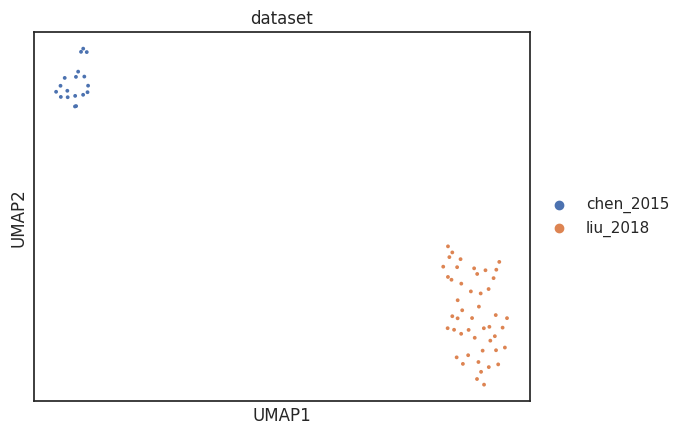

In [14]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["dataset"],
    ncols=1,
    # Setting a smaller point size to get prevent overlap
    size=30,
)

In [ ]:
break

# Neighbor Graph (no PCA of embeddings)

In [ ]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["cell_type", "dataset", "n_counts", "length"],
    ncols=1,
    size=30,
)

In [ ]:
break

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(adata.X)

adata.obs['UMAP 1'] = embedding[:, 0]
adata.obs['UMAP 2'] = embedding[:, 1]

adata

In [ ]:
adata.obs['dataset'].unique()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='none',
                lw=0.1,
                alpha=0.9,
                hue='dataset',
                s=5)


plt.xticks([])
plt.yticks([])


sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

# Neighbor Graph (no PCA of embeddings)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["cell_type", "dataset"],
    n_cols=1,
    # Setting a smaller point size to get prevent overlap
    size=10,
)

In [ ]:
break

In [ ]:
comp_1 = 4
comp_2 = 5

sns.scatterplot(data=embs,
                x=comp_1,
                y=comp_2,
                ec='none',
                lw=0.1,
                alpha=0.9,
                hue='dataset',
                s=5)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
sc.tl.pca(adata, n_comps=5)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="cell_type",
    # Setting a smaller point size to get prevent overlap
    size=10,
)

In [ ]:
break

In [ ]:
sc.tl.leiden(adata, n_iterations=2)
sc.pl.umap(adata, color=["leiden"])

In [ ]:
break

In [ ]:
sns.scatterplot(data=embs,
                x=0,
                y=1,
                hue='dataset',
                s=10)

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
break

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=21)
sc.tl.umap(adata, min_dist=0.2)

adata

In [ ]:
sc.pl.umap(adata, 
           color=['dataset'])

In [ ]:
break

In [ ]:
df = embs.copy()

sns.scatterplot(data=df,  
                x=0,
                y=2,
                alpha=0.6,
                s=10,
                palette="Set1",
                # legend=False,
                hue='dataset')

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1))
